In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(nn.BatchNorm2d(input_channels), nn.ReLU(),
                         nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1))
                         

In [5]:
class dense_block(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(dense_block, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(conv_block(input_channels + num_channels* i, num_channels))
        
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        for layer in self.net:
            y = layer(X)
            X = torch.cat((X,y), dim=1)
        return X

In [6]:
blk = dense_block(2, 3, 10)

X = torch.randn(4,3,8,8)

y = blk(X)
y.shape

torch.Size([4, 23, 8, 8])

In [7]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
        
    )

In [8]:
blk = transition_block(23,10)
blk(y).shape

torch.Size([4, 10, 4, 4])

In [9]:
# creating Densenet

b1 = nn.Sequential(nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [10]:
num_channels = 64
growth_rate = 32

num_of_convs_in_dense_blocks = [4,4,4,4]

blks = []

for i, num_convs in enumerate(num_of_convs_in_dense_blocks):
    blks.append(dense_block(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate
    if i != len(num_of_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels//2))
        num_channels = num_channels // 2

In [11]:
net= nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels),nn.ReLU(),
                   nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(num_channels, 10))

In [23]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): dense_block(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
#d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [13]:
from torchsummary import summary

summary(net.to(torch.device('cuda')), (1,96,96))

z:\installs\anconda\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           3,200
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 32, 24, 24]          18,464
       BatchNorm2d-8           [-1, 96, 24, 24]             192
              ReLU-9           [-1, 96, 24, 24]               0
           Conv2d-10           [-1, 32, 24, 24]          27,680
      BatchNorm2d-11          [-1, 128, 24, 24]             256
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]          36,896
      BatchNorm2d-14          [-1, 160,

## Exercises
1. Why do we use average pooling rather than maximum pooling in the transition layer?
- so that theother cells may not be eliminated and have some value addition in the model

2. One of the advantages mentioned in the DenseNet paper is that its model parameters are
smaller than those of ResNet. Why is this the case?
- because of less number of linear layers, more memory is utilised instead disk space( I am ssuming because of the follow up question given below)

```
Total params: 758,226
Trainable params: 758,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 14.29
Params size (MB): 2.89
Estimated Total Size (MB): 17.22
```

This is the disk space, while the memory used in 3.1 GB.

3. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to 224 × 224 to see the actual GPU
    memory consumption.
    ```
    Total params: 758,226
    Trainable params: 758,226
    Non-trainable params: 0
    ----------------------------------------------------------------
    Input size (MB): 0.19
    Forward/backward pass size (MB): 77.81
    Params size (MB): 2.89
    Estimated Total Size (MB): 80.89
    ```
    
    2. Can you think of an alternative means of reducing the memory consumption? How
    would you need to change the framework?
    - no Idea. Maybe focus on storing varibale rather than using it in the memory.
    
4. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper
(Huang et al., 2017).

- https://arxiv.org/pdf/1608.06993.pdf

5. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price
prediction task in Section 4.10.

-  This is a task! But how? I am low on motivation.


In [21]:
# training loop for densenet
import matplotlib.pyplot as plt

def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == y).sum().float().mean()

def init_weights(m):
    if type(m)==nn.Linear or type(m)==nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
    
def train_net(net, train_dataloader, test_dataloader, n_epochs=10, lr=0.1, batch_size=256,device=torch.device('cuda')):
        
    net.apply(init_weights)
    print('training on: ', device)
    net = net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr )
    loss_criterion = nn.CrossEntropyLoss()
    
    train_acc_arr = []
    train_loss_arr = []
    test_acc_arr = []
    
    for epoch in range(n_epochs):
        net.train()
        train_acc = 0
        train_loss = 0
        number = 0
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
        
            y_hat = net(X)
            train_acc += accuracy(y_hat, y).item()
            #print(train_acc * len(y))
            optimizer.zero_grad()
            loss = loss_criterion(y_hat, y)
            train_loss += loss.item()
            
            #print(train_loss*10, train_acc/10)
            
            number += len(y)
            loss.backward()        
            optimizer.step()
        
        train_acc_arr.append(train_acc/number)
        train_loss_arr.append((train_loss/number) *100)
        
        net.eval()
        test_acc = 0
        with torch.no_grad():
            number_test = 0 
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
            
                y_hat = net(X)
                test_acc += accuracy(y_hat, y).item()
                number_test += len(y)
        
            test_acc_arr.append(test_acc/number_test)
                
        print(f'train_acc, train_loss, test_acc : {train_acc_arr[-1]}, {train_loss_arr[-1]}, {test_acc_arr[-1]}')
    
    
    plt.plot(range(n_epochs),train_acc_arr )
    plt.plot(range(n_epochs),test_acc_arr )
    plt.plot(range(n_epochs),train_loss_arr)
    plt.show()        

training on:  cuda
train_acc, train_loss, test_acc : 0.7872166666666667, 0.2578543589512507, 0.8427
train_acc, train_loss, test_acc : 0.8799, 0.12611655476192635, 0.8329
train_acc, train_loss, test_acc : 0.9009333333333334, 0.10417473054180543, 0.8771
train_acc, train_loss, test_acc : 0.9116333333333333, 0.09339966493348281, 0.7978
train_acc, train_loss, test_acc : 0.9205166666666666, 0.08460599350432556, 0.8863


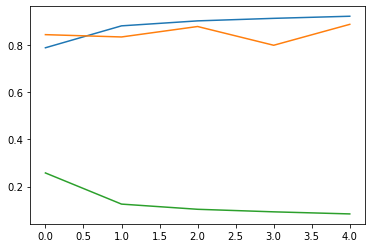

Wall time: 7min 57s


In [22]:
%%time
train_net(net, train_iter, test_iter, n_epochs=5)

In [20]:
summary(net, (1,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          18,464
       BatchNorm2d-8           [-1, 96, 56, 56]             192
              ReLU-9           [-1, 96, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          27,680
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
           Conv2d-13           [-1, 32, 56, 56]          36,896
      BatchNorm2d-14          [-1, 160,

In [ ]:
#5 
## Designing MLP  with Densenet

